# *Object Tracking* (Seguimiento de objetos)
El seguimiento de objetos es una tarea importante dentro del campo de *computer vision*. En este post consideramos la metodologia de *object tracking* conocida como *tracking-by-detection* donde los resultados de la detección de objetos se dan en cada *frame* como *input* y el objetivo es asociar las detecciones para encontrar las trayectorias de los objetos. No se puede esperar que se detecten todos los objetos en cada cuadro, puede haber falsas detecciones y algunos objetos pueden ser ocluidos por otros; estos factores hacen que la asociación de datos sea una tarea difícil, pero en este post nos vamos a limitar al problema donde las detecciones son perfectas.

Comenzamos revisando la fórmula del problema *tracking-by-detection*, siguiendo de cerca la formulación utilizada en (PONER REFERENCIAS). Asumimos la existencia de $z^{(i)}_t$, que corresponde a la detección $i$ realizada en el tiempo $t$. Notese que no se especifica la forma de la detección (por ejemplo, *bounding box*, *feature vector*, trazas de *optical-flow*). Denotamos el conjunto de todas las detecciones en un video como $\mathbf{\hat{Z}}$. Además, definimos una *track* $\mathbf{x}^{(k)} = \{z^{(i)}_{t_0}, \cdots, z^{(i)}_{t_{T_k}}\}$ como una lista ordenada de detecciones que contiene toda la información necesaria para rastrear un objeto incluyendo, pero no limitándose, a su ubicación actual. Estos *tracks* codifican los cambios que experimenta el objeto $k$ desde el momento de su primera detección efectiva hasta la última, proporcionando la noción de persistencia necesaria para distinguir los objetos entre sí dentro de un vídeo. Definimos el conjunto de todos los *tracks* de $K$ como $\mathbf{X} = \{ \mathbf{x}^{(1)}, \cdots, \mathbf{x}^{(K)}\}$.

Utilizando la formulación de *tracking-by-detection*, pretendemos maximizar la probabilidad posterior de $\mathbf{X}$ dado $\mathbf{\hat{Z}}$, como

\begin{equation}
    \begin{aligned}
       \operatorname*{max}_\mathbf{X} p(\mathbf{X} | \mathbf{\hat{Z}}) & = \operatorname*{max}_\mathbf{X} p( \mathbf{\hat{Z}} | \mathbf{X}) p(\mathbf{X}) \\
        & = \operatorname*{max}_\mathbf{X} \prod_{i,t} p(\mathbf{z}^{(i)}_{t} | \mathbf{X}) \prod_{k}  p(\mathbf{x}^{(k)}),
    \end{aligned}
    \tag{1}\label{1}
\end{equation}

donde asumimos una independencia condicional entre detecciones dada una colección de *tracks*; e independencia entre los *tracks*, esto significa queel movimiento de cada objeto es independiente. Es difícil optimizar la ecuacion anterior directamente, porque el espacio de $\mathbf{X}$ es enorme, sin embargo, podemos reducir el tamaño del espacio de búsqueda utilizando la observación de que un objeto sólo puede pertenecer a una trayectoria. Esto se traduce en la restricción de que los *tracks* no puede superponerse entre sí, es decir, $\mathbf{x}^{(k)}  \cap \mathbf{x}^{(l)} = \varnothing \mbox{  }, \forall k \neq l$. Asumimos además que las transiciones de *tracks* siguen un modelo de Markov de primer orden $p(\mathbf{x}^{(k)}) = p(x^{(k)}_{t_0}) \prod_{t} p(x^{(k)}_{t_{l}} | x^{(k)}_{t_{l-1}})$.

La ecuación $\eqref{1}$ muestra que el problema de *tracking-by-detection* puede descomponerse en dos subproblemas: evaluar la probabilidad de las detecciones $p( \mathbf{\hat{Z}} | \mathbf{X})$  (por ejemplo, ignorar las detecciones que muestran un movimiento improbable, evaluar la necesidad de nuevos *tracks*) y modelar el movimiento de los objetos $p(\mathbf{x}^{(k)})$.
## Tipos de *object tracking*
Partiendo de la ecuacion $\eqref{1}$ y de las asunciones anteriores, se puede modelar el problema de *tracking-by-detection* de dos formas concidas en la literatura como las formulaciones *batch* y *online*.

Metodos *online* como (PONER REFERENCIAS) asocian las detecciones del *frame* entrante inmediatamente a las trayectorias existentes y, por lo tanto, son apropiadas para aplicaciones en tiempo real, asimismo las trayectorias son modeladas como *linear state space models*, por ejemplo filtros de Kalman o filtros de particulas. La asociación a las detecciones en el *frame* actual se formula a menudo como una problema de asignacion binaria y se resuelve mediante el algoritmo húngaro.

Metodos *batch* como (PONER REFERENCIAS) consideran observaciones pasadas, presentes y futuras o incluso toda la secuencia a la vez. Aunque no es aplicable en tiempo real, la ventaja de los métodos *batch* es el contexto temporal, que permite realizar predicciones más robustas. Una solución elegante para asignar trayectorias a las detecciones es la formulación *network flow* introducida en (PONER REFERENCIAS).

### *Batch object tracking*
(IMAGE)

Los metodos *batch* se pueden representar como un grafo (Ver imagen) donde cada detección $\mathbf{z}_t$ se representa con dos nodos conectados por un borde (en rojo en la imagen). A este borde se le asigna la variable de flujo $y^{det}_{t}$. Para poder asociar dos detecciones que pertenecen a la misma trayectoria $\mathbf{X}$, se añaden al gráfico bordes dirigidos (en azul en la imagen) de todos los $\mathbf{z}_t$ a todos los $\mathbf{z}_{t'}$ tal que $t < t'$ y $\vert t - t'\vert < \tau_t$. A cada uno de estos bordes se le asigna una variable de flujo $y^{link}_{t, t'}$. El hecho de tener bordes en múltiples cuadros permite manejar oclusiones o detecciones fallidas. Para reducir el tamaño del gráfico, eliminamos bordes entre las detecciones que están espacialmente distantes, esto lo que la variable $\tau_t$ representa. Esta elección se basa en la suposición de los objetos de mueven aproximandamente con movimiento rectilineo uniforme en instantes cortos de tiempo. Para manejar el nacimiento y la muerte de las trayectorias, se añaden dos nodos especiales al gráfico. Un nodo fuente ($S$) se conecta con el primer nodo de cada detección con un borde (negro en la imagen) al que se le asigna la variable de flujo $y^{in}_t$. Asimismo, el segundo nodo de cada detección está conectado con un nodo de sumidero ($T$) y al borde correspondiente (negro) se le asigna la variable $y^{out}_t$. Cada variable del gráfico está asociada a un costo. Para cada uno de los cuatro tipos de variables definimos el costo correspondiente, es decir, $c^{in}_t = -\text{log } p(x^{(k)}_{t})$, $c^{out}_T = -\text{log } p(x^{(k)}_{T})$, $c^{det}_t = -\text{log } p( \mathbf{z}_{t} | \mathbf{X})$ y $c^{link}_{t, t'} = -\text{log }p(x^{(k)}_{t} | x^{(k)}_{t'})$, que resulta de aplicarel logaritmo a la ecuacion $\eqref{1}$ y cambiar el problema de maximizacion a uno de minimizacion introduciendo un signo menos. Esto nos deja con el siguiente problema de proramacion lineal conocido como *Minimum-cost flow*:
\begin{equation}
\begin{aligned}
& {\text{min}}
&& z = \displaystyle\sum_{\mathbf{x}^{(k)} \in \mathbf{X}} \left( c^{in}_{t_0} y^{in}_{t_0}  + c^{out}_{t_{T_k}} y^{out}_{t_{T_k}} +  \sum_{l>0} c^{link}_{t_{l+1}, t_{l}} y^{link}_{t_{l+1}, t_{l}} \right)  + \sum_t c^{det}_t y^{det}_{t} \\
&&& z = \sum_{t} c^{in}_{t} y^{in}_{t} + \sum_{t} c^{out}_{t} y^{out}_{t} \sum_{t, t'} c^{link}_{t, t'} y^{link}_{t, t'} + \sum_{t} c^{det}_t y^{det}_{t} \\
&\text{s.t.}
&&  y^{in}_{t} + \sum_{t'} y^{link}_{t, t'} =  y^{det}_{t}\\
&&& y^{out}_t + \sum_{t'} y^{link}_{t, t'} = y^{det}_{t} \\
&&& y^{in}_{t}, y^{link}_{t, t'}, y^{out}_t, y^{det}_{t} \in \{0, 1\} \\
\end{aligned}
\end{equation}
Encontrar la hipótesis de asociación óptima $\mathbf{X}^\star$ es equivalente a enviar el flujo de la fuente $S$ al sumidero $T$ que minimiza el costo. Cada trayectoria de flujo puede ser interpretada como la trayectoria de un objeto, la cantidad de flujo enviada de $S$ a $T$ es igual al número de trayectorias de objetos en el video, y el costo total del flujo corresponde al *loglikelihood* de la hipótesis de asociación. Las restricciones de conservación del flujo garantizan que ningún flujo comparta un borde común y, por lo tanto, que no se superpongan las trayectorias.

### *Online object tracking*
Los metodos *online* toman un enfoque *greddy* optando por reolver el problema de *tracking-by-detection* para cda *frame*, es decir, en $t=0$ todas las detecciones $z^{(i)}_0$ se asumen correctas y correspondientes a objetos distintos, y se las asocia con un *track* para cada detecion (este paso, aunque restrictivo es necesario para inicializar la solucion), luego una variante recursiva de la ecuacion $\eqref{1}$ es resuelta:
\begin{equation}
    \begin{aligned}
          & \operatorname*{max}_{\mathbf{X}} p(\mathbf{X}_t \vert \mathbf{Z}_{t}, \mathbf{X}_{t-1}^{\star}) 
    \end{aligned}
    \tag{2}\label{2}
\end{equation}
La detección de objetos obtiene las detecciones $\mathbf{Z}_{t}$ aplicando un detector pre-entrenado en el *frame* $t$. Luego se  encuentran las asociaciones óptimas entre $\mathbf{Z}_{t}$ y $\mathbf{X}_{t-1}^{\star}$ para formar la estimación actual de las trayectorias $\mathbf{X}_t$. Los *tracks* obtenidos utilizando el proceso definido por la ecuacion $\eqref{2}$ no son necesariamente óptimas en cuanto a la maximización de la distribución definida por la ecuacion $\eqref{1}$. Dado que el número de todas las enumeraciones posibles de $\mathbf{X}_t$ dadas las trayectorias optimas $\mathbf{X}_{t-1}^{\star}$ encontradas en $t-1$  y las detecciones $\mathbf{Z}_{t}$ es enorme, resolver directamente la ecuacion $\eqref{2}$ es intratable.
Simplificamos aun mas es problema resolviendo únicamente un problema de asociación de datos entre $\mathbf{X}_{t-1}^{\star}$ y $\mathbf{Z}_{t}$, para luego obtener las trayectorias óptimas $\mathbf{X}_t^{\star}$ actualizando $\mathbf{X}_{t-1}^{\star}$ con las detecciones asociadas. Hacemos esto definiendo una matriz de asignación $\Psi = [\Psi_{i,j}]_{n \times m}$ para representar la asociación entre $\mathbf{X}_{t-1}^{\star}$ y  $\mathbf{Z}_{t}$ , donde cada entrada $\Psi_{i,j} \in \{0,1\}$ indica si la detección $j$-esima está asociada a la trayectoria $i$-esima o no.  Luego, el problema de la asociación de datos se expresa como un problema de estimacion *MAP*

\begin{equation}
\begin{aligned}
\Psi^{\star} & = {\text{argmax}} \displaystyle\sum_{i,j} \Psi_{i,j} \text{log } p(\Psi_{i,j}=1 \vert \mathbf{Z}_{t} \mathbf{X}_{t-1}), \\
\text{s.t.} & \displaystyle\sum_{i} \Psi_{i,j} = 1 \mbox{  }, \forall j \\
& \displaystyle\sum_{j} \Psi_{i,j} = 1 \mbox{  }, \forall i
\end{aligned}
\end{equation} 
donde $p(\Psi_{i,j}=1 \vert \mathbf{Z}_{t} \mathbf{X}_{t-1})$ es la probabilidad de asociación posterior cuando la detección $j$-esima se asocia a la trayectoria $i$-esima. Asumimos que las asociaciones de todos los pares de trayectoria y detección son independientes. La tarea es buscar la asignación óptima $\Psi^{\star}$ que maximiza la probabilidad de asociación posterior.
Varios tipos de *trackers* pueden existir dependiendo de como modelemos la probabilidad de asociación posterior $\text{log } p(\Psi_{i,j}=1 \vert \mathbf{Z}_{t} \mathbf{X}_{t-1})$, uno de los mas importantes es el *Kalman tracker* que aproxima la probabilidad de asociacion con la distancia de Mahalanobis $(\mathbf{z}^{(i)}_{t} - \mathbf{x}^{(j)}_{t})^{\intercal} \Sigma^{-1}_{t} (\mathbf{z}^{(i)}_{t} - \mathbf{x}^{(j)}_{t})$ o la medida de *IoU* (*Intersection over Union*) entre las detecciones y los *tracks*. 
La distancia IOU entre las detecciones y los *tracks* maneja implícitamente la oclusión a corto plazo causada por los objetivos que pasan dado que favorece adecuadamente las detecciones con una escala similar.  Esto permite que tanto el objetivo oclusor se corrija con la detección mientras que el objetivo cubierto no se ve afectado por la falta de asignación. Asimismo cuando se usa la distancia de Mahalanobis, la matriz $\Sigma$ es la matriz de incertidumbre obtenida del filtro de Kalman y su incorporación es ventajosa por dos razones: (1) la asignación de *tracks* a detecciones lejanas se vuelve improbable; y (2) la oclusión a corto plazo puede ser manejada cuando la incertidumbre de movimiento es baja.

## Implementando *Online object tracking*

In [1]:
from collections import OrderedDict

import numpy as np
import pandas as pd
from datasets import MovingMNIST, SiameseMNIST
from sort import Sort

import motmetrics as mm
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as patches
from matplotlib import rc
mpl.rcParams['savefig.pad_inches'] = 0
mpl.rcParams['animation.html'] = 'html5'
# rc('animation', html='html5')

In [3]:
num_digits = 4
digits = np.array([0, 2, 4, 6, 8])
seq_len = 100

In [4]:
dset = MovingMNIST(True, seq_len=seq_len, num_digits=num_digits, digits=digits)

In [5]:
seq, bbox = dset[0]

In [6]:
bbox[0]

tensor([[ 13.,  13.,  41.,  41.,   1.],
        [ 39.,  83.,  67., 111.,   2.],
        [ 79.,  37., 107.,  65.,   3.],
        [ 78.,  33., 106.,  61.,   0.]], dtype=torch.float64)

In [7]:
def plot_gt(seq):
    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    def update(i):
        im.set_data(seq[i, :, :, 0])
        for j in range(bbox.shape[1]):
            x, y = bbox[i, j, 0], bbox[i, j, 1]
            w, h = 28, 28
            rects[j].set_width(w)
            rects[j].set_height(h)
            rects[j].set_xy([x, y])
    im = ax.imshow(seq[0, :, :, 0], cmap='gray', aspect='auto')
    rects = [0]*bbox.shape[1]
    for j in range(bbox.shape[1]):
        x, y = bbox[0, j, 0], bbox[0, j, 1]
        w, h = 28, 28
        rects[j] = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rects[j])
    ax.set_xticks([])
    ax.set_yticks([])

    ax.get_xaxis().set_ticklabels([])
    ax.get_yaxis().set_ticklabels([])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ani = animation.FuncAnimation(fig,
                              update,
                              seq.shape[0],
                              interval=1000/5,
                              blit=False)
    return ani

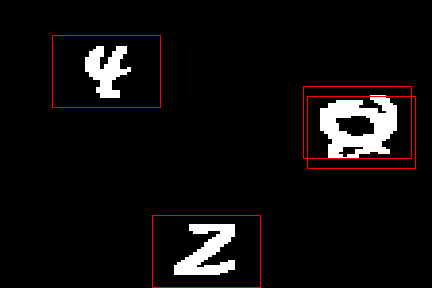

In [8]:
ani = plot_gt(seq)
ani

### Kalman tracker

In [50]:
def compare_dataframes(gts, ts):
    accs = []
    names = []
    for k, tsacc in ts.items():
        if k in gts.keys():
            accs.append(mm.utils.compare_to_groundtruth(list(gts.items())[k][1], tsacc, 'iou', distth=0.5))
            names.append(k)
    return accs, names

In [7]:
num_digits = 5
test_digits = np.array([1, 3, 5, 7, 9])
seq_len = 100
test_dset = MovingMNIST(True, seq_len=seq_len, num_digits=num_digits, digits=test_digits)

In [59]:
gt = []
dt = []
names = ['FrameId', 'X', 'Y', 'Width', 'Height', 'Id', 'Confidence', 'ClassId', 'Visibility']
for i in range(100): # len(test_dset)
    seq, bbox = test_dset[i]
    bbox = bbox.numpy()
    tracker = Sort()
    trks_ = np.zeros((0, 9))
    for t in range(bbox.shape[0]):
        dets = bbox[t].copy()
        if np.random.uniform() < 0.1:
            idel = np.random.randint(dets.shape[0])
            dets = np.delete(dets, (idel), axis=0)
        dets[:, -1] = 1 # remove ground truth id replace with condifence
        trks = tracker.update(dets)
        trks[:, 2] = trks[:, 2] - trks[:, 0]
        trks[:, 3] = trks[:, 3] - trks[:, 1]
        trks = np.concatenate(((t + 1) * np.ones((trks.shape[0],1)), trks), axis=1)
        trks = np.concatenate((trks, np.ones((trks.shape[0],3))), axis=1)
        trks_ = np.concatenate((trks_, trks), axis=0)
    dt_df = pd.DataFrame(trks_,
                         columns=names)
    dt_df.index = pd.MultiIndex.from_arrays(dt_df[['FrameId', 'Id']].values.T, names=['FrameId', 'Id'])
    del dt_df['FrameId']
    del dt_df['Id']
    dt.append(dt_df)
    # ground truth
    framesid = np.repeat(np.arange(1, seq_len+1), num_digits)
    bbox_ = bbox.reshape((-1, 5))
    bbox_ = np.concatenate((framesid.reshape(framesid.shape[0],1), bbox_), axis=1)
    bbox_ = np.concatenate((bbox_, np.ones((framesid.shape[0],3))), axis=1)
    bbox_[:, 3] = 28
    bbox_[:, 4] = 28
    gt_df = pd.DataFrame(bbox_,
                         columns=names)
    gt_df.index = pd.MultiIndex.from_arrays(gt_df[['FrameId', 'Id']].values.T, names=['FrameId', 'Id'])
    del gt_df['FrameId']
    del gt_df['Id']
    gt.append(gt_df)

In [60]:
gt = OrderedDict([(i, df) for i, df in enumerate(gt)])
dt = OrderedDict([(i, df) for i, df in enumerate(dt)])
mh = mm.metrics.create()
accs, names = compare_dataframes(gt, dt)
summary = mh.compute_many(accs, names=names, metrics=mm.metrics.motchallenge_metrics, generate_overall=True)

In [61]:
print(mm.io.render_summary(summary, formatters=mh.formatters, namemap=mm.io.motchallenge_metric_names))

         IDF1    IDP   IDR  Rcll   Prcn  GT  MT PT ML FP   FN IDs   FM  MOTA  MOTP
0       78.7%  82.5% 75.2% 91.2% 100.0%   4   4  0  0  0   35   2   13 90.8% 0.084
1       98.6% 100.0% 97.2% 97.2% 100.0%   4   4  0  0  0   11   0    4 97.2% 0.058
2       95.1%  97.4% 93.0% 95.0%  99.5%   4   4  0  0  2   20   2    7 94.0% 0.081
3       81.1%  86.6% 76.2% 88.0% 100.0%   4   4  0  0  0   48   2   12 87.5% 0.094
4       87.6%  91.3% 84.2% 92.2% 100.0%   4   4  0  0  0   31   1   10 92.0% 0.087
5       70.6%  72.9% 68.5% 94.0% 100.0%   4   4  0  0  0   24   3    9 93.2% 0.087
6       97.3% 100.0% 94.8% 94.8% 100.0%   4   4  0  0  0   21   0    5 94.8% 0.066
7       81.8%  86.0% 78.0% 90.5%  99.7%   4   4  0  0  1   38   3   14 89.5% 0.103
8       53.9%  55.7% 52.2% 93.2%  99.5%   4   4  0  0  2   27   7    9 91.0% 0.106
9       61.3%  64.7% 58.2% 90.0% 100.0%   4   4  0  0  0   40   5   10 88.8% 0.099
10      78.5%  81.1% 76.0% 93.8% 100.0%   4   4  0  0  0   25   4    7 92.8% 0.089
11  

### Aperance *tracker*

In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

#### Train Siamese Network for features

In [3]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss
    Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """

    def __init__(self, margin, reduction='sum'):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9
        self.reduction = reduction

    def forward(self, x_, x, target):
        distances = (x_ - x).pow(2).sum(1)  # squared distances
        losses = 0.5 * (target.float() * distances +
                        (1 + -1 * target).float() * F.relu(self.margin - (distances + self.eps).sqrt()).pow(2))
        if self.reduction == 'sum':
            return losses.sum()
        elif self.reduction == 'mean':
            return losses.mean()
        else:
            NotImplementedError('Unknown reduction')

In [4]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        self.convnet = nn.Sequential(nn.Conv2d(1, 32, 5), nn.ReLU(),
                                     nn.MaxPool2d(2, stride=2),
                                     nn.Conv2d(32, 64, 5), nn.ReLU(),
                                     nn.MaxPool2d(2, stride=2))

        self.fc = nn.Sequential(nn.Linear(64 * 4 * 4, 256),
                                nn.ReLU(),
                                nn.Linear(256, 256),
                                nn.ReLU())

    def forward(self, x):
        output = self.convnet(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output


class SiameseNet(nn.Module):
    def __init__(self, embedding_net):
        super(SiameseNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        return output1, output2

    def get_embedding(self, x):
        return self.embedding_net(x)

In [5]:
# from ignite.contrib.handlers import ProgressBar
from ignite.engine import (Engine, Events, create_supervised_evaluator,
                           create_supervised_trainer)
from ignite.handlers import EarlyStopping, ModelCheckpoint, TerminateOnNan
from ignite.metrics import Loss, RunningAverage

In [6]:
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

train_dataset = SiameseMNIST(True, digits=np.array([0, 2, 4, 6, 8]))
print(len(train_dataset))
test_dataset = SiameseMNIST(False, digits=np.array([0, 2, 4, 6, 8]))
print(len(test_dataset))
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

margin = 1.
embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)
# if cuda:
#     model.cuda()
criterion = ContrastiveLoss(margin, reduction='mean')
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)

def evaluate_function(engine, batch):
    if device:
        model.to(device)
    model.eval()
    with torch.no_grad():
        x1, x2, target = batch
        if device:
            x1 = x1.to(device)
            x2 = x2.to(device)
            target = target.to(device)
        y1, y2 = model(x1, x2)
        kwargs = {'target': target} # 'output1': y1, 'output2': y2, 
    return y1, y2, kwargs

def process_function(engine, batch):
    if device:
        model.to(device)
    model.train()
    optimizer.zero_grad()
    x1, x2, target = batch
    if device:
        x1 = x1.to(device)
        x2 = x2.to(device)
        target = target.to(device)
    y1, y2 = model(x1, x2)
    loss = criterion(y1, y2, target)
    loss.backward()
    optimizer.step()
    return loss.item()
        
trainer = Engine(process_function)
evaluator = Engine(evaluate_function)
training_history = {'loss':[]}
validation_history = {'loss':[]}

Loss(criterion).attach(evaluator, 'nll')
RunningAverage(output_transform=lambda x: x).attach(trainer, 'loss')

def score_function(engine):
    val_loss = engine.state.metrics['nll']
    return -val_loss

handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)
evaluator.add_event_handler(Events.COMPLETED, handler)

@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    loss = engine.state.metrics['loss']
    training_history['loss'].append(loss)
    print("Training Results - Epoch: {}  Avg loss: {:.2f}".format(trainer.state.epoch, loss))

def log_validation_results(engine):
    evaluator.run(test_loader)
    metrics = evaluator.state.metrics
    loss = metrics['nll']
    validation_history['loss'].append(loss)
    print("Validation Results - Epoch: {} Avg loss: {:.2f}".format(trainer.state.epoch, loss))
trainer.add_event_handler(Events.EPOCH_COMPLETED, log_validation_results)

def val_score(engine):
    evaluator.run(test_loader)
    avg_loss = evaluator.state.metrics['nll']
    return -avg_loss


checkpointer = ModelCheckpoint('./models',
                               'SiameseNet',
                               score_function=val_score,
                               score_name='loss',
                               n_saved=2,
                               create_dir=True,
                               save_as_state_dict=True,
                               require_empty=False)

trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {'SiameseNet': model})
trainer.add_event_handler(Events.ITERATION_COMPLETED, TerminateOnNan())

29492
4926


In [7]:
trainer.run(train_loader, max_epochs=20)

Training Results - Epoch: 1  Avg loss: 6.33
Validation Results - Epoch: 1 Avg loss: 0.07
Training Results - Epoch: 2  Avg loss: 0.04
Validation Results - Epoch: 2 Avg loss: 0.04
Training Results - Epoch: 3  Avg loss: 0.03
Validation Results - Epoch: 3 Avg loss: 0.03
Training Results - Epoch: 4  Avg loss: 0.02
Validation Results - Epoch: 4 Avg loss: 0.02
Training Results - Epoch: 5  Avg loss: 0.02
Validation Results - Epoch: 5 Avg loss: 0.02
Training Results - Epoch: 6  Avg loss: 0.01
Validation Results - Epoch: 6 Avg loss: 0.02
Training Results - Epoch: 7  Avg loss: 0.01
Validation Results - Epoch: 7 Avg loss: 0.01
Training Results - Epoch: 8  Avg loss: 0.01
Validation Results - Epoch: 8 Avg loss: 0.01
Training Results - Epoch: 9  Avg loss: 0.01
Validation Results - Epoch: 9 Avg loss: 0.01
Training Results - Epoch: 10  Avg loss: 0.01
Validation Results - Epoch: 10 Avg loss: 0.01
Training Results - Epoch: 11  Avg loss: 0.01
Validation Results - Epoch: 11 Avg loss: 0.01
Training Results 

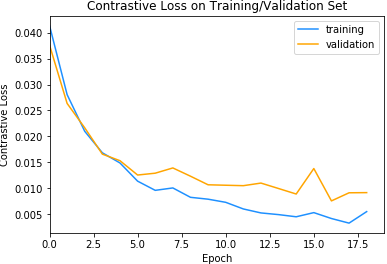

In [9]:
training_history['loss'] = training_history['loss'][1:]
validation_history['loss'] = validation_history['loss'][1:]
plt.plot(range(len(training_history['loss'])), training_history['loss'], 'dodgerblue', label='training')
plt.plot(range(len(validation_history['loss'])), validation_history['loss'], 'orange', label='validation')
plt.xlim(0, len(validation_history['loss']));
plt.xlabel('Epoch')
plt.ylabel('Contrastive Loss')
plt.title('Contrastive Loss on Training/Validation Set')
plt.legend()

#### Train relational netowrk